In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import scipy.io as io
import keras_contrib
import datetime


In [30]:
from PIL import Image
import zipfile
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from IPython import display

In [31]:
tf.compat.v1.enable_eager_execution()

In [32]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [33]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [34]:
# 目标尺寸
IMG_WIDTH = 256
IMG_HEIGHT = 256
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [35]:
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

In [36]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [37]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [38]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [39]:
BUFFER_SIZE = 400
BATCH_SIZE = 1

train_dataset = tf.data.Dataset.list_files('./data_mountain/'+'*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [40]:
test_dataset = tf.data.Dataset.list_files('./test_mountain/'+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [41]:
def encoder_block(filters):
    initialiter=tf.random_normal_initializer(0,0.02)
    
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters,3,strides=2,padding='same',kernel_initializer=initialiter,use_bias=False))
    block.add(keras_contrib.layers.InstanceNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [42]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
          tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [43]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [44]:
def Generator():
    
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.layers.Input(shape=[256,256,3])#语义
    inputs2=tf.keras.layers.Input(shape=[256,256,3])#图片
    #风格编码
    encoder_blocks=[
        encoder_block(64),
        encoder_block(128),
        encoder_block(256),
        encoder_block(512),
        encoder_block(512),
        encoder_block(512)
    ]
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 512)+(bs, 2, 2, 512)=(bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    x11=inputs2
    x1=inputs
    for block in encoder_blocks:
        x11=block(x11)
    x11=tf.keras.layers.Flatten()(x11)
    
    x11=tf.keras.layers.Dense(256)(x11)
    x22=tf.keras.layers.Dense(256)(x11)
    
    std=tf.exp(x22*0.5)
    eps=tf.random.normal(tf.shape(x22))
    result=eps*std+x11
    x2=result
    
    x2=tf.keras.layers.Flatten()(x2)
    x2=tf.keras.layers.Dense(16384)(x2)
    x2=tf.reshape(x2,[-1,64,64,4])
    x2=tf.keras.layers.Conv2DTranspose(3,7,strides=4,padding='same',kernel_initializer=initializer,use_bias=False)(x2)
    x2=tf.keras.layers.BatchNormalization()(x2)
    x2=tf.keras.layers.LeakyReLU()(x2)#256,256,3
    
    x2=tf.keras.layers.Conv2D(128,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x2)
    x2=tf.keras.layers.ReLU()(x2)
    gamma=tf.keras.layers.Conv2D(3,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x2)
    beta=tf.keras.layers.Conv2D(3,3,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(x2)
    x=gamma*x1+beta
    
    x=tf.keras.layers.BatchNormalization()(x)
    
    
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 3)
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)  # 第一个x是(bs, 1, 1, 512)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=[inputs,inputs2], outputs=x)

In [45]:
Generator().summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_69 (Sequential)      (None, 128, 128, 64) 1730        input_12[0][0]                   
__________________________________________________________________________________________________
sequential_70 (Sequential)      (None, 64, 64, 128)  73730       sequential_69[0][0]              
__________________________________________________________________________________________________
sequential_71 (Sequential)      (None, 32, 32, 256)  294914      sequential_70[0][0]              
_______________________________________________________________________________________

In [46]:
def dis_block(filters):
    initializer=tf.random_normal_initializer(0,0.02)
    
    block=tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters,4,strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
    block.add(keras_contrib.layers.InstanceNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    
    return block

In [47]:
def Discriminator():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    inputs2=tf.keras.layers.Input(shape=[256,256,3])
    x=tf.keras.layers.concatenate([inputs,inputs2])
    
    initializer=tf.random_normal_initializer(0,0.02)
    
    dis_blocks=[
        dis_block(64),
        dis_block(128),
        dis_block(256),
    ]
    for block in dis_blocks:
        x=block(x)
    x=tf.keras.layers.Conv2D(512,2,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False)(x)
    x=keras_contrib.layers.InstanceNormalization()(x)
    x=tf.keras.layers.LeakyReLU()(x)
    
    x=tf.keras.layers.Conv2D(512,2,strides=1,padding='valid',kernel_initializer=initializer,use_bias=False)(x)
    x1=tf.nn.sigmoid(x)
    
    return tf.keras.Model(inputs=[inputs,inputs2],outputs=x1)

In [48]:
Discriminator().summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
sequential_90 (Sequential)      (None, 128, 128, 64) 6146        concatenate_23[0][0] 

In [49]:
def vgg19():
    inputs=tf.keras.layers.Input([256,256,3])
    x=inputs
    model=tf.keras.applications.VGG19(input_shape=(256,256,3),weights='imagenet',include_top=False)
    model.trainable=False
    slice1=tf.keras.Sequential()
    slice2=tf.keras.Sequential()
    slice3=tf.keras.Sequential()
    slice4=tf.keras.Sequential()
    slice5=tf.keras.Sequential()
    
    for i in range(4):
        slice1.add(model.layers[i])
    for i in range(4,7):
        slice2.add(model.layers[i])
    for i in range(7,12):
        slice3.add(model.layers[i])
    for i in range(12,17):
        slice4.add(model.layers[i])
    for i in range(17,22):
        slice5.add(model.layers[i])
    
    x1=slice1(x)
    x2=slice2(x1)
    x3=slice3(x2)
    x4=slice4(x3)
    x5=slice5(x4)
    
    return tf.keras.Model(inputs=inputs,outputs=[x1,x2,x3,x4,x5])

In [50]:
def Generator_loss(target,gen_dis_image,gen_image):#gen_image:(512,512,3) 
    gan_loss=loss_object(tf.ones_like(gen_dis_image),gen_dis_image)
    
    weight=[1/32,1/16,1/8,1/4,1]
    x_1=vgg19()(gen_image)
    x_11=vgg19()(target)
    l1_loss=0
    for i in range(len(x_1)):
        l1_loss=l1_loss+weight[i]*tf.reduce_mean(tf.abs(x_1[i]-x_11[i]))
    total_gen_loss=gan_loss+LAMBDA*l1_loss
    
    return total_gen_loss,l1_loss

In [51]:
def Discriminator_loss(target_dis,gen_dis_image):
    
    real_loss=loss_object(tf.ones_like(target_dis),target_dis)
    generated_loss=loss_object(tf.zeros_like(gen_dis_image),gen_dis_image)
    
    total_dis_loss=real_loss+generated_loss
    return total_dis_loss

In [52]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [53]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [54]:
generator=Generator()
discriminator=Discriminator()


In [55]:
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([input_image,target], training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss,gen_l1_loss = Generator_loss(target, disc_generated_output, gen_output)
        disc_loss = Discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    

In [59]:
def generate_images(model2, test_input, target):
    prediction = model2([test_input,target], training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [60]:
def fit(train_ds, epochs, test_ds):
    num=len(train_ds.enumerate())
    for epoch in range(epochs):
        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(Generator(), example_input, example_target)
        #print("Epoch: ", epoch)
        print("\r总进度完成%.2f %%" % (epoch *100 /epochs), end="")
        print()
        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print("\r子进度完成%.2f %%" % (n *100 /num), end="")
            time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            if time[11:13]=='00':
                tf.saved_model.save(Generator(),'./Generator_mountain.h5')
                tf.saved_model.save(Discriminator(),'./Discriminator_mountain.h5')
                tf.saved_model.save(Image_Encoder(),'./Image_Encoder_mountain.h5')
                print(epoch,n)
                    

            train_step(input_image, target, epoch)
        print()

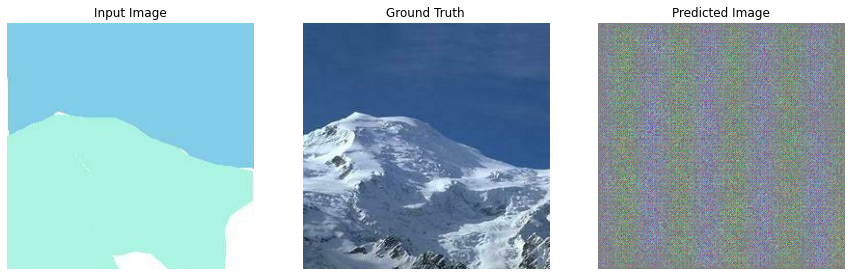

总进度完成0.00 %
子进度完成13.64 %

ResourceExhaustedError: OOM when allocating tensor with shape[1,65536,1152] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Conv2DBackpropInput]

In [61]:
EPOCHS = 100
fit(train_dataset, EPOCHS, test_dataset)